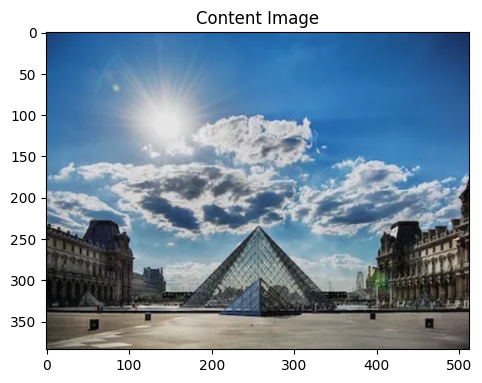

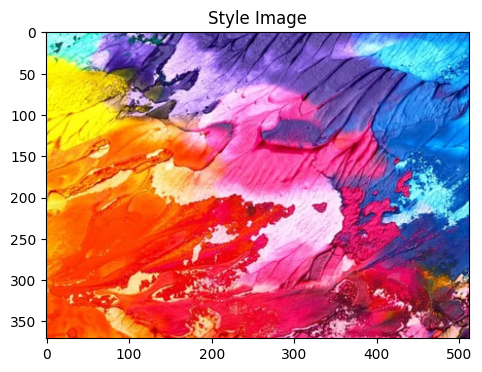

....................

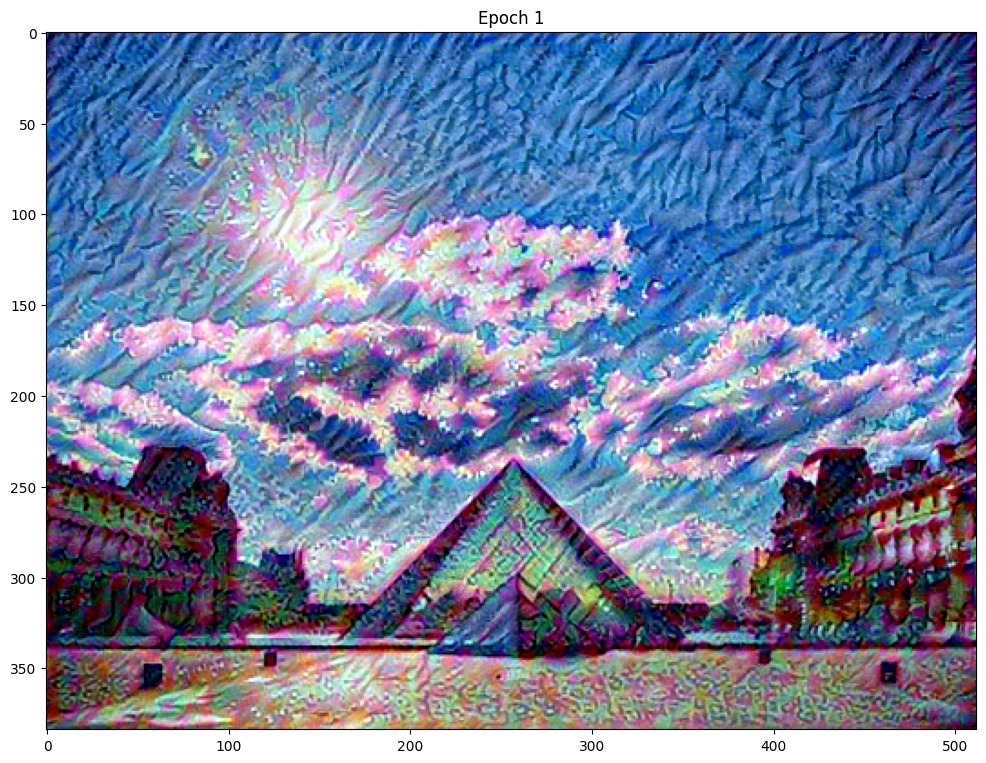

Total time: 114.1 seconds


In [1]:
# Import necessary libraries
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time

# Configure environment
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['axes.grid'] = False

# Helper functions
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Load images
content_path = "1.png"
style_path = "2.png"
content_image = load_img(content_path)
style_image = load_img(style_path)

# Display images
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Load VGG19 model
def vgg_layers(layer_names):
    """Creates a VGG19 model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Define style and content layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Define StyleContentModel class
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

# Create the model
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Initialize the image to optimize
image = tf.Variable(content_image)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Loss weights
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

# Define loss functions
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Run the optimization
epochs = 1
steps_per_epoch = 20

start = time.time()

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
        print(".", end='', flush=True)
    plt.imshow(tensor_to_image(image))
    plt.title(f"Epoch {n + 1}")
    plt.show()

end = time.time()
print(f"Total time: {end - start:.1f} seconds")

# Save the result
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

# Optionally download the image if running in Google Colab
try:
    from google.colab import files
    files.download(file_name)
except (ImportError, AttributeError):
    pass


In [2]:
def edge_detection(image):
    # Convert to grayscale
    image_gray = tf.image.rgb_to_grayscale(image)
    
    # Get sobel edges (output shape: [batch_size, height, width, 2, 1])
    sobel_edges = tf.image.sobel_edges(image_gray)
    
    # sobel_x and sobel_y correspond to the gradients in the x and y directions, respectively
    sobel_x = sobel_edges[..., 0, 0]  # Gradient in the x direction
    sobel_y = sobel_edges[..., 0, 1]  # Gradient in the y direction
    
    # Calculate the edge magnitude
    edge_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    
    return edge_magnitude


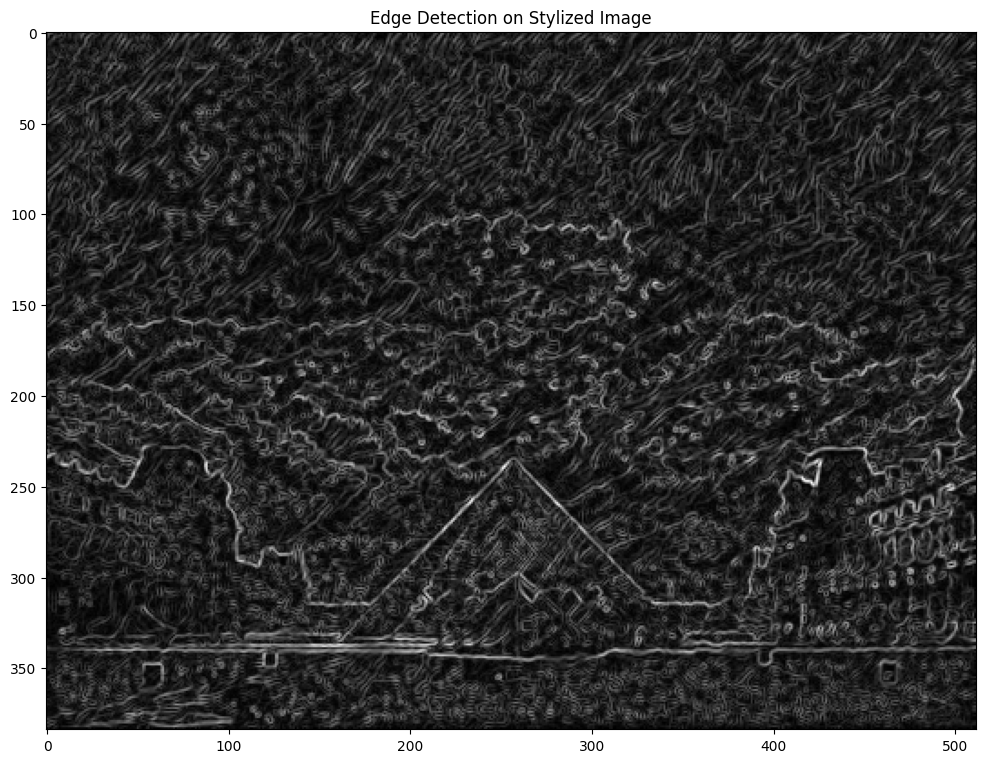

In [3]:
# Load the stylized image
stylized_image_path = "stylized-image.png"
stylized_image = load_img(stylized_image_path)

# Perform edge detection on the loaded image
edge_image = edge_detection(stylized_image)

# Display the edge-detected image
plt.imshow(tf.squeeze(edge_image), cmap='gray')
plt.title("Edge Detection on Stylized Image")
plt.show()


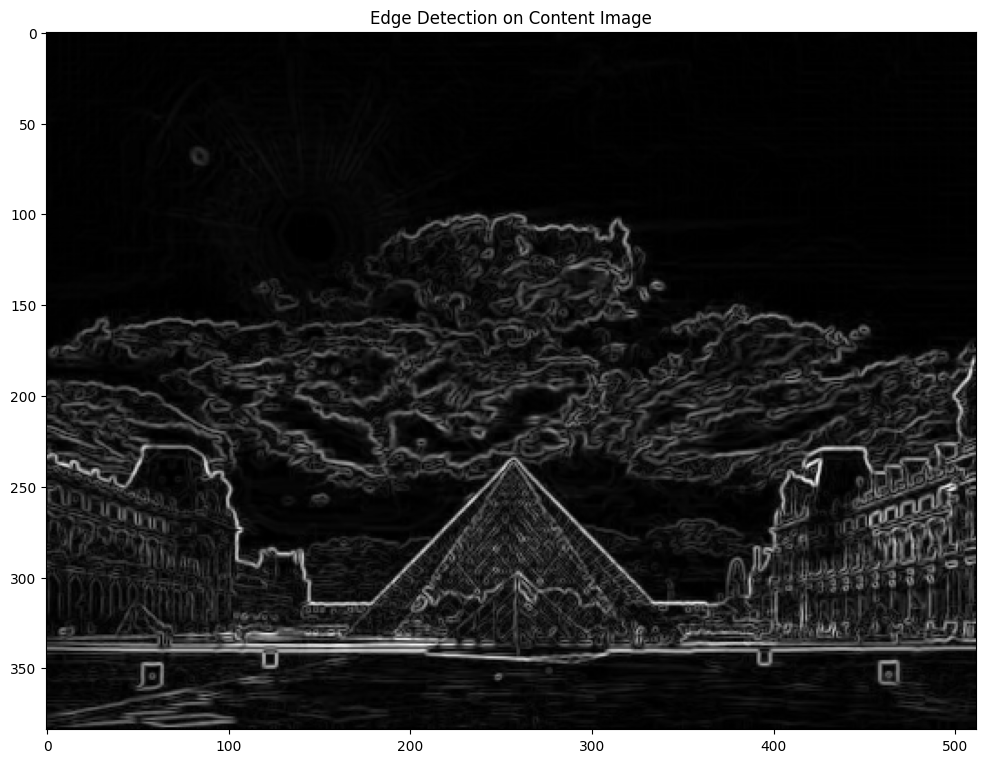

In [4]:
# Perform edge detection on the content image
edge_image = edge_detection(content_image)

# Display the edge-detected image
plt.imshow(tf.squeeze(edge_image), cmap='gray')
plt.title("Edge Detection on Content Image")
plt.show()

In [5]:
def high_pass_x_y(image):
    # Calculate x and y gradients using difference
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    # Pad the results to make the shapes compatible for addition
    x_var = tf.pad(x_var, [[0, 0], [0, 0], [0, 1], [0, 0]])
    y_var = tf.pad(y_var, [[0, 0], [0, 1], [0, 0], [0, 0]])
    
    return x_var, y_var


In [ ]:
def salient_map(image):
    x_var, y_var = high_pass_x_y(image)
    gradient_magnitude = tf.sqrt(tf.square(x_var) + tf.square(y_var))
    return gradient_magnitude

# Create a salient map from the content image
salient_image = salient_map(stylized_image)

# Display the salient map
plt.imshow(tf.squeeze(salient_image), cmap='gray')
plt.title("Salient Map of OUTPUT Image")
plt.show()


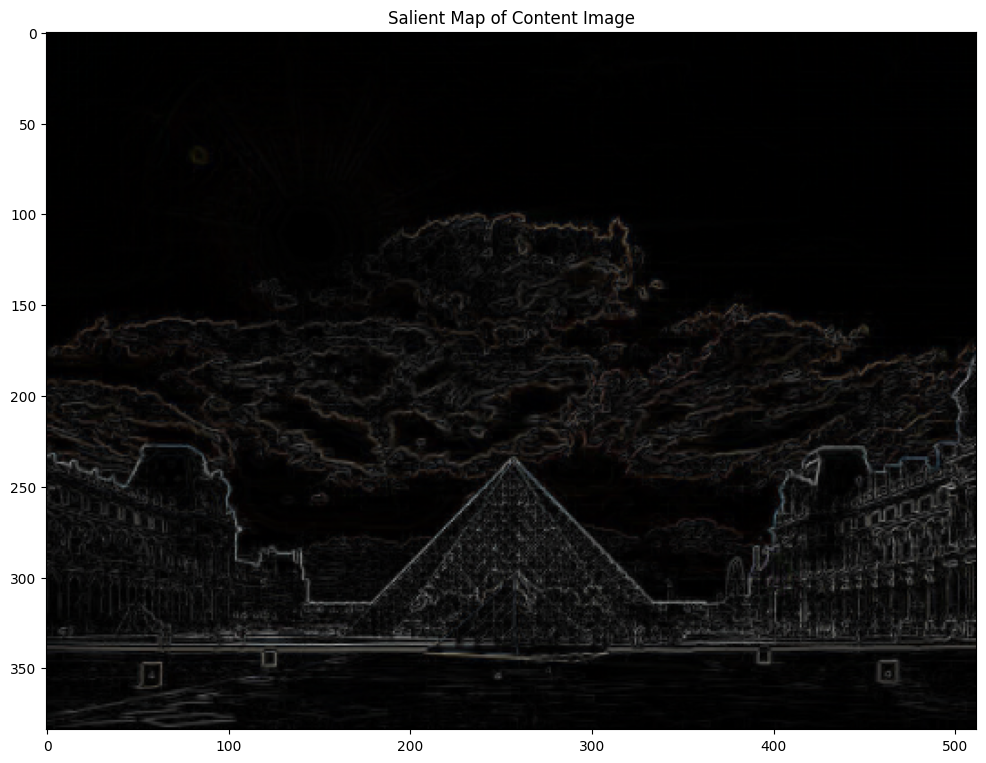

In [7]:
def salient_map(image):
    x_var, y_var = high_pass_x_y(image)
    gradient_magnitude = tf.sqrt(tf.square(x_var) + tf.square(y_var))
    return gradient_magnitude

# Create a salient map from the content image
salient_image = salient_map(content_image)

# Display the salient map
plt.imshow(tf.squeeze(salient_image), cmap='gray')
plt.title("Salient Map of Content Image")
plt.show()
